In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt


In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import accuracy_score, mean_absolute_error,mean_squared_error
    
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import keras
from keras import regularizers
from keras.layers import LSTM
from keras.layers import Input, Dense, LSTM, SimpleRNN, TimeDistributed
from keras.models import Model

C:\Users\abhik\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
prat_df = pd.read_csv('arturo_prat_qc.csv', parse_dates=["# observation_time"], index_col="# observation_time")
prat_df.head()

,latitude,longitude,air_temperature (degC),dew_point_temperature (degC),wind_direction (deg),wind_speed (m/s),sea_level_pressure (hPa),station_pressure (hPa),relative_humidity (%),low_cloud_area_fraction (code),low_cloud_type (code),middle_cloud_type (code),high_cloud_type (code),visibility (code)
# observation_time,,,,,,,,,,,,,,
1983-01-01 00:00:00,-62.5,-59.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1983-01-01 03:00:00,-62.5,-59.7,1.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1983-01-01 06:00:00,-62.5,-59.7,0.6,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1983-01-01 09:00:00,-62.5,-59.7,0.8,NaN,0.0,0.0,990.7,990.1,NaN,NaN,NaN,NaN,NaN,NaN
1983-01-01 12:00:00,-62.5,-59.7,1.0,NaN,0.0,0.0,991.6,991.0,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
prat_df.dropna(axis=1, how='all', inplace=True)

In [5]:
prat_df.drop(columns=['longitude', 'latitude'], inplace=True)

In [6]:
prat_df = prat_df.fillna(0)

In [7]:
prat_daily = prat_df.resample('D').mean()

In [8]:
sam = pd.read_excel('sam_sample_month.xlsx', parse_dates=True, index_col='date')

In [9]:
sam_daily = sam.resample('D').ffill()

In [10]:
result = pd.concat([prat_daily.reset_index(drop=True), sam_daily.reset_index(drop=True)], axis=1)

In [11]:
result.drop(columns=['station_pressure (hPa)'], inplace=True)

In [31]:
result.head()

,air_temperature (degC),wind_direction (deg),wind_speed (m/s),sea_level_pressure (hPa),temp
0,1.1625,0.00,0.0000,620.8000,-2.44
1,1.9625,0.00,0.0000,998.1625,-2.44
2,2.3875,143.75,1.5125,1006.0500,-2.44
3,2.4000,152.50,5.4125,996.7500,-2.44
4,1.7625,242.50,11.0625,986.3500,-2.44


In [39]:
temp = 0 # index of the appropriate column
y = np.expand_dims(X[0:, temp], -1)

In [40]:
X = result.drop(columns=['air_temperature (degC)'], axis=1)
X=X.fillna(0)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

pipeline = Pipeline([
    ('scaling', StandardScaler()),
])

X = pipeline.fit_transform(X)


In [41]:
print(X.shape)
print(y.shape)

(7670, 4)
(7670, 1)


In [42]:
def train_test_split_time_series_regres(X, y, test_ratio=0.15):
    total_samples = X.shape[0]
    train_idx = int(total_samples * (1-test_ratio))
    XTrain = X[:train_idx]
    yTrain = y[:train_idx]
    XTest = X[train_idx:]
    yTest = y[train_idx:]
    return XTrain, yTrain, XTest, yTest

In [43]:
XTrain, yTrain, XTest, yTest = train_test_split_time_series_regres(X, y)
print(XTrain.shape)
print(yTrain.shape)
print(XTest.shape)
print(yTest.shape)


(6519, 4)
(6519, 1)
(1151, 4)
(1151, 1)


In [44]:
def reshape_to_batches(matrix, batch_size):
    batch_num = np.ceil(matrix.shape[0] / batch_size)
    modulo = batch_num * batch_size - matrix.shape[0]
    if modulo != 0: 
        padding = np.zeros((int(modulo), matrix.shape[1]))
        matrix = np.vstack((matrix, padding))
        
    return np.array(np.split(matrix, batch_num))



In [58]:
BATCH_SIZE = 100
XTrain_batch = reshape_to_batches(XTrain, BATCH_SIZE)
yTrain_batch = reshape_to_batches(yTrain, BATCH_SIZE)
print(XTrain_batch.shape)
print(yTrain_batch.shape)


(66, 100, 4)
(66, 100, 1)


In [59]:
BATCH_SIZE = 100
XTest_batch = reshape_to_batches(XTest, BATCH_SIZE)
yTest_batch = reshape_to_batches(yTest, BATCH_SIZE)
print(XTest_batch.shape)
print(yTest_batch.shape)


(12, 100, 4)
(12, 100, 1)


In [60]:
#import all dependencies
from keras.layers import Input, Dense, LSTM, TimeDistributed
from keras.models import Model
from keras.layers.recurrent import GRU

In [61]:
inputs = Input(shape=(BATCH_SIZE, 4))

In [62]:
lstm = LSTM(64, activation='tanh', recurrent_activation='hard_sigmoid', use_bias=True, 
            kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', 
            bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, 
            recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, 
            kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.2, 
            recurrent_dropout=0.3, implementation=1, return_sequences=True, return_state=False, 
            go_backwards=False, stateful=False, unroll=False)(inputs)

predictions = TimeDistributed(Dense(1, activation='linear'))(lstm)
lstm_model256 = Model(inputs=inputs, outputs=predictions)
lstm_model256.compile(optimizer='adam',
                      loss='mean_squared_error',
                      metrics=['accuracy'])
lstm_model256.fit(XTrain_batch, yTrain_batch, epochs=100)

Epoch 1/100
66/66 [==============================] - 2s 23ms/step - loss: 0.9040 - acc: 0.0123
Epoch 2/100
66/66 [==============================] - 0s 4ms/step - loss: 0.7965 - acc: 0.0123
Epoch 3/100
66/66 [==============================] - 0s 4ms/step - loss: 0.7080 - acc: 0.0123
Epoch 4/100
66/66 [==============================] - 0s 3ms/step - loss: 0.6630 - acc: 0.0123
Epoch 5/100
66/66 [==============================] - 0s 3ms/step - loss: 0.6160 - acc: 0.0123
Epoch 6/100
66/66 [==============================] - 0s 3ms/step - loss: 0.6043 - acc: 0.0123
Epoch 7/100
66/66 [==============================] - 0s 3ms/step - loss: 0.6406 - acc: 0.0123
Epoch 8/100
66/66 [==============================] - 0s 3ms/step - loss: 0.6434 - acc: 0.0123
Epoch 9/100
66/66 [==============================] - 0s 3ms/step - loss: 0.5758 - acc: 0.0123
Epoch 10/100
66/66 [==============================] - 0s 3ms/step - loss: 0.5643 - acc: 0.0123
Epoch 11/100
66/66 [==============================] - 0s 3

Epoch 87/100
66/66 [==============================] - 0s 3ms/step - loss: 0.0985 - acc: 0.0123
Epoch 88/100
66/66 [==============================] - 0s 3ms/step - loss: 0.0970 - acc: 0.0123
Epoch 89/100
66/66 [==============================] - 0s 3ms/step - loss: 0.1029 - acc: 0.0123
Epoch 90/100
66/66 [==============================] - 0s 3ms/step - loss: 0.0866 - acc: 0.0123
Epoch 91/100
66/66 [==============================] - 0s 3ms/step - loss: 0.0755 - acc: 0.0123
Epoch 92/100
66/66 [==============================] - 0s 3ms/step - loss: 0.0776 - acc: 0.0123
Epoch 93/100
66/66 [==============================] - 0s 3ms/step - loss: 0.0856 - acc: 0.0123
Epoch 94/100
66/66 [==============================] - 0s 3ms/step - loss: 0.1082 - acc: 0.0123
Epoch 95/100
66/66 [==============================] - 0s 3ms/step - loss: 0.1106 - acc: 0.0123
Epoch 96/100
66/66 [==============================] - 0s 3ms/step - loss: 0.0806 - acc: 0.0123
Epoch 97/100
66/66 [==============================

In [63]:
def _3d_to_2d(arr):
    return arr.reshape(arr.shape[0]*arr.shape[1],arr.shape[2])


In [66]:
y_pred_lstm_256 = lstm_model256.predict(XTest_batch)

print(yTest.shape)
print(y_pred_lstm_256.shape)

print("MAE: {0:.2f}".format(mean_absolute_error(yTest, _3d_to_2d(y_pred_lstm_256)[:1151])))
print("MSE: {0:.2f}".format(mean_squared_error(yTest, _3d_to_2d(y_pred_lstm_256)[:1151])))



(1151, 1)
(12, 100, 1)
MAE: 0.10
MSE: 0.02


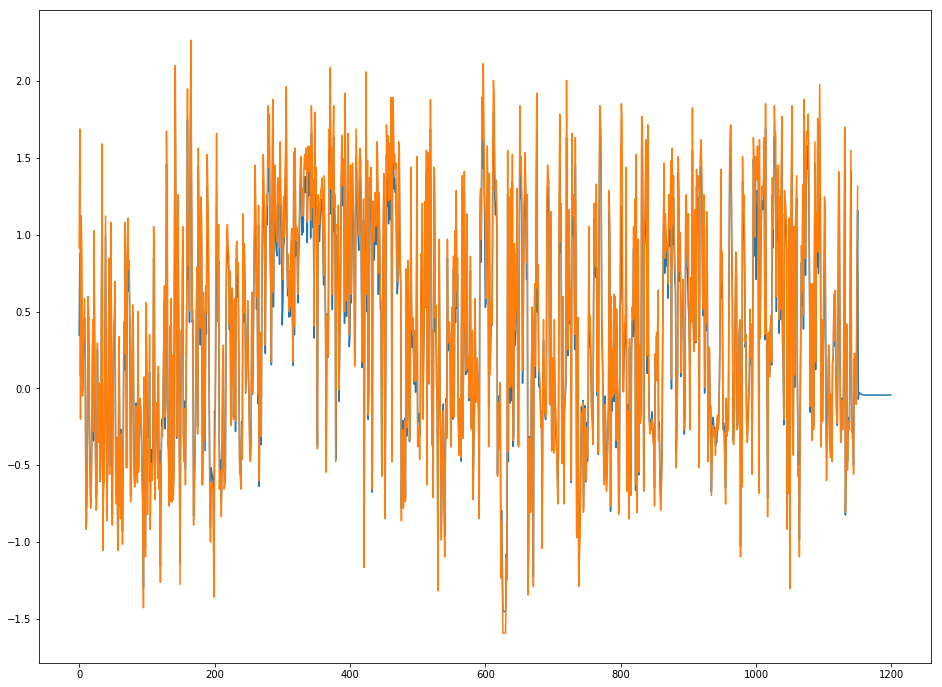

In [71]:
plt.figure(figsize=(16, 12))

plt.plot(_3d_to_2d(y_pred_lstm_256)[:7315])
plt.plot(yTest)
plt.savefig('prat_daily_lstm.png')

plt.show()
